# Import

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
# sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [2]:
import json
import os
# path = os.getcwd()
path = r'H:\Shared drives\SLab\Multimode\experiment\250708_qsim' # for data 
print("path: ", path)

path:  H:\Shared drives\SLab\Multimode\experiment\250708_qsim


# Setup experiment hardware

In [3]:
expt_path=path+'\\data'

print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data


In [4]:
curr_path = os.getcwd()
# config_file = curr_path+'\\configs\\config_rfsoc_ziqian.yml'
config_file = curr_path+'\\configs\\hardware_config_202505.yml'
config_path = config_file
print('Config will be', config_path)

exp_param_file = curr_path+'\\configs\\experiment_config.yml'
exp_param_path = exp_param_file
print('Exp Param will be', exp_param_path)

Config will be c:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Exp Param will be c:\_Lib\python\multimode_expts\configs\experiment_config.yml


In [52]:
qubit_i = 0
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [6]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab

In [7]:
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [8]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x18eddd38850; not connected; for PYRO:obj_65d5568241f84ce6b086ad472fc0670a@192.168.137.101:38179>


In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)

QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

# Choose experiment name

In [10]:
import sys

# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
# if expts_path not in sys.path:
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', '/home/xilinx/jupyter_notebooks/', 'C:\\_Lib\\pytho

# Floquet pulse calibrations

## Datset for Sidebands

In [11]:
from dataset import *
from dataset import floquet_storage_swap_dataset
import os 

file_path = os.path.join(expts_path, 'floquet_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds = floquet_storage_swap_dataset(file_path)

ds_thisrun = floquet_storage_swap_dataset(ds.create_copy())
ds_thisrun_file_path = os.path.join(expts_path, ds_thisrun.filename)
ds_thisrun.df

Creating a copy of the dataset at path: floquet_storage_swap_dataset_copy.csv


,stor_name,pi_frac,freq (MHz),gain (DAC units),len (mus),ramp_sigma (mus),phase_from_M1-S1 (deg),phase_from_M1-S2 (deg),phase_from_M1-S3 (deg),phase_from_M1-S4 (deg),phase_from_M1-S5 (deg),phase_from_M1-S6 (deg),phase_from_M1-S7 (deg),last_update
0,M1-S1,12,348.712183,950,0.160000,0.005008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-08-05 17:09:28.508539
1,M1-S2,12,519.958427,1651,0.275000,0.005008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-08-05 17:57:19.670955
2,M1-S3,12,696.032259,1697,0.250000,0.005008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-08-06 16:18:41.642880
3,M1-S4,12,873.338368,2996,0.306719,0.005008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-08-01 16:32:41.566552
4,M1-S5,12,1053.097573,2500,0.401374,0.005008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-08-01 16:32:41.571538
5,M1-S6,12,1245.006393,4500,0.309916,0.005008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-08-01 16:32:41.577525
6,M1-S7,12,1422.461718,3333,0.572427,0.005008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025-08-01 16:32:41.583507


In [12]:
file_path = os.path.join(expts_path, 'man1_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds_storage = storage_man_swap_dataset(file_path)
ds_storage.df

,stor_name,freq (MHz),precision (MHz),pi (mus),h_pi (mus),gain (DAC units),last_update
0,M1-S1,348.702402,NaN,0.917427,0.445843,3000,2025-07-22 15:51:50.161175
1,M1-S2,520.137038,NaN,1.084582,0.539466,5000,2025-07-22 15:54:56.677904
2,M1-S3,695.783956,NaN,1.314576,0.658091,4887,2025-07-22 17:53:49.923683
3,M1-S4,873.338368,NaN,1.221390,0.613439,8988,2025-07-22 17:54:24.902793
4,M1-S5,1053.097573,NaN,1.595772,0.802749,7500,2025-06-30 02:27:09.054687
5,M1-S6,1245.006393,NaN,1.253407,0.619833,13500,2025-06-30 02:30:07.599645
6,M1-S7,1422.461718,NaN,2.293646,1.144853,10000,2025-06-30 02:33:06.360285
7,M1-S8,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3
8,M1-S9,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3
9,M1-S10,-1.000000,-1.00,-1.000000,-1.000000,-1,51:31.3


In [13]:
ds_thisrun.get_columns()

['stor_name',
 'pi_frac',
 'freq (MHz)',
 'gain (DAC units)',
 'len (mus)',
 'ramp_sigma (mus)',
 'phase_from_M1-S1 (deg)',
 'phase_from_M1-S2 (deg)',
 'phase_from_M1-S3 (deg)',
 'phase_from_M1-S4 (deg)',
 'phase_from_M1-S5 (deg)',
 'phase_from_M1-S6 (deg)',
 'phase_from_M1-S7 (deg)',
 'last_update']

In [14]:
# Initializing this run dataset to some guess values based on standard storage pulses

# for s in range(1, 8, 1):
#     stor_name = f'M1-S{s}'
#     pi_frac = 12
#     freq = ds_storage.get_freq(f'M1-S{s}')
#     gain = ds_storage.get_gain(f'M1-S{s}') / 3
#     length = ds_storage.get_h_pi(f'M1-S{s}') / 2
#     ramp_sigma = soc.cycles2us(2, gen_ch=1)
#     stark_shift = 0.0
#     ds_thisrun.update_all(stor_name, pi_frac, freq, gain, length, ramp_sigma, stark_shift) 

# # Save dataset to file
# ds.df = ds_thisrun.df.copy()
# ds.save_to_file(ds.filename)

In [ ]:
# file_path_old = os.path.join(expts_path, 'floquet_storage_swap_dataset_backup.csv')
# # print(os.makedirs(file_path, exist_ok=True))
# ds_backup = floquet_storage_swap_dataset(file_path_old)
# ds_backup.df

,stor_name,pi_frac,freq (MHz),gain (DAC units),len (mus),ramp_sigma (mus),stark_shift (MHz),last_update
0,M1-S1,12,348.712183,950,0.160000,0.005008,0.0,2025-08-05 17:09:28.508539
1,M1-S2,12,519.958427,1651,0.275000,0.005008,0.0,2025-08-05 17:57:19.670955
2,M1-S3,12,696.033956,1629,0.260000,0.005008,0.0,2025-08-05 17:52:21.024507
3,M1-S4,12,873.338368,2996,0.306719,0.005008,0.0,2025-08-01 16:32:41.566552
4,M1-S5,12,1053.097573,2500,0.401374,0.005008,0.0,2025-08-01 16:32:41.571538
5,M1-S6,12,1245.006393,4500,0.309916,0.005008,0.0,2025-08-01 16:32:41.577525
6,M1-S7,12,1422.461718,3333,0.572427,0.005008,0.0,2025-08-01 16:32:41.583507


In [ ]:
# # Initializing this run dataset to some values from another csv with different columns

# for s in range(1, 8, 1):
#     stor_name = f'M1-S{s}'
#     for col in ds_thisrun.df.columns:
#         if col in ds_backup.df.columns:
#             ds_thisrun.df[col] = ds_backup.df[col].copy()
#     # ds_thisrun.update_all(stor_name, pi_frac, freq, gain, length, ramp_sigma, stark_shift) 
# ds_thisrun.df
# # Save dataset to file
# ds.df = ds_thisrun.df.copy()
# ds.save_to_file(ds.filename)

Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv


In [14]:
config_thisrun = AttrDict(deepcopy(yaml_cfg))
config_thisrun.device.storage.floquet_man_stor_file = ds_thisrun_file_path

In [15]:
from MM_dual_rail_base import MM_dual_rail_base
def get_floquet_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        stor_mode_no: Storage mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    freq = ds_thisrun.get_freq(stor_name)
    gain = ds_thisrun.get_gain(stor_name)
    length = ds_thisrun.get_len(stor_name)
    pi_frac = ds_thisrun.get_pi_frac(stor_name)
    ch = 'low' if freq < 1000 else 'high'

    mm_base_dummy = MM_dual_rail_base(config_thisrun, soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, length, pi_frac, ch, prepulse, postpulse


## Freq chevron

Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv
Updating gain for M1-S3 to 1908


  0%|          | 0/30 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00009_FloquetChevron_S3.h5
('Error in saving cfg into datafile (experiment.py):', TypeError('Object of type floquet_storage_swap_dataset is not JSON serializable'))


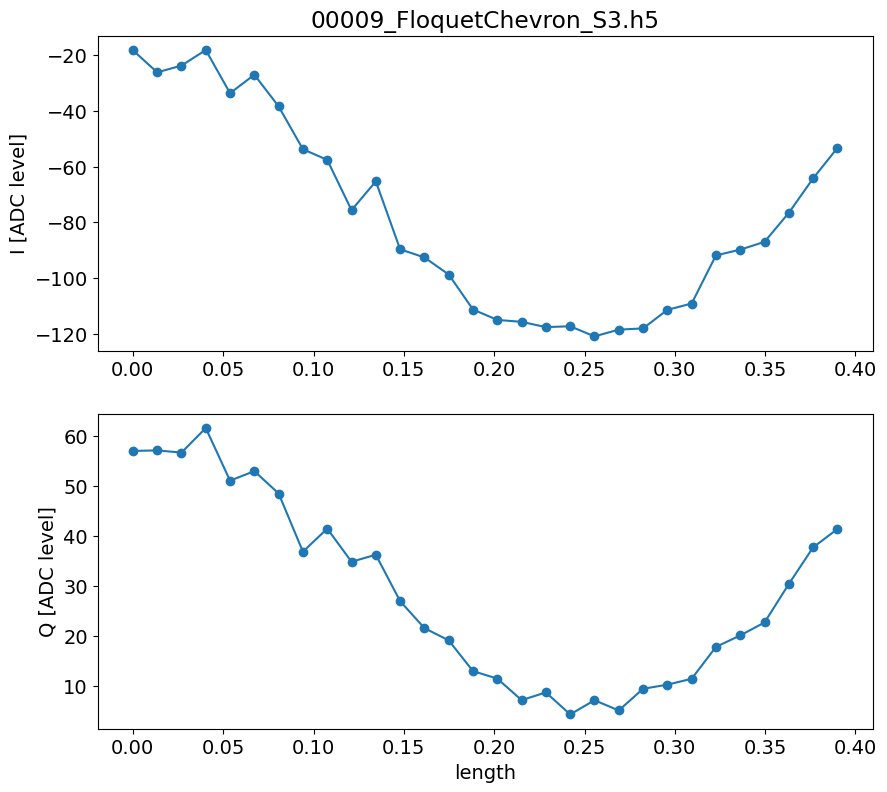

In [96]:
stor_modes_to_run = [3]
freq_len_expt = [None] * len(stor_modes_to_run)

for i, init_stor in enumerate(stor_modes_to_run): #range(1,8):
    ro_stor = 0

    # ds_thisrun.update_gain(f'M1-S{init_stor}', ds_thisrun.get_gain(f'M1-S{init_stor}') * 0.75)
    # print(f'Updating gain for M1-S{init_stor} to {ds_thisrun.get_gain(f"M1-S{init_stor}")}')

    expt_params = dict(
        expts = 1,
        reps = 100,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        # detunes=np.linspace(-0.2, 0.2, 10).tolist(),
        # lengths=np.linspace(0, 1.5 * ds_thisrun.get_len(f'M1-S{init_stor}'), 10).tolist(),
        # swept_params = ['detune', 'length'],
        detune = 0,
        lengths=np.linspace(0, 1.5 * ds_thisrun.get_len(f'M1-S{init_stor}'), 30).tolist(),
        swept_params = ['length'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        ds_thisrun=ds_thisrun,
    )
    
    qbe = meas.FloquetChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"FloquetChevron_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params=expt_params,
        program=meas.FloquetChevronProgram,
        progress=True)
    
    qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    qbe.go(analyze=False, display=True, progress=True, save=True)
    freq_len_expt[i] = qbe

In [ ]:
qbe = freq_len_expt[0]
# qbe.analyze()
stor_name = f'M1-S{qbe.cfg.expt.init_stor}'
# ds_thisrun.update_len(stor_name, 0.250)
# ds_thisrun.update_freq(stor_name, ds_thisrun.get_freq(stor_name) - 0.02)

## Error amplification on floquet pulses

In [20]:
def do_error_amp_floquet(
    config_thisrun,
    ds_thisrun,
    expt_path,
    config_path,
    reps=100,
    rounds=1,
    qubit=0,
    n_pulses=10,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500, 
    span = 1.0, # in units of either freq or gain depending on parameter_to_test
    expts = 25,
    parameter_to_test = 'frequency',
    man_mode_no=1,
    stor_mode_no=1,
    stor_is_dump=False,
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    freq, gain, length, pi_frac, ch, prepulse, postpulse = get_floquet_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    pulse_type = ['floquet', f'M{man_mode_no}-{"D" if stor_is_dump else "S"}{stor_mode_no}', f'pi/{pi_frac}', 0]


    if parameter_to_test == 'frequency':
        start = freq - span / 2
        step = span / (expts - 1)
    elif parameter_to_test == 'gain':
        start = int(gain - span / 2)
        step = int(span / (expts - 1))
    else:
        raise ValueError("parameter_to_test must be either 'frequency' or 'gain'.")
    
    expt_cfg = {
        'reps': reps,
        'qubit': qubit,
        'qubits': [qubit],
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'start': start,
        'expts': expts,
        'step': step,
        'n_pulses': n_pulses,
        'pulse_type': pulse_type,
        'parameter_to_test': parameter_to_test,
        'rounds': rounds,
    }

    error_amp_exp = meas.single_qubit.error_amplification.ErrorAmplificationExperiment(
    soccfg=soc, path=expt_path,
      prefix='ErrorAmplificationExperiment', config_file=config_path)
    error_amp_exp.cfg = AttrDict(deepcopy(config_thisrun))
    error_amp_exp.cfg.expt = expt_cfg
    error_amp_exp.go(analyze=False, display=False, progress=True, save=True)
    return error_amp_exp

In [ ]:
stor_modes_to_run = [3]
error_amp_gain1 = [None] * len(stor_modes_to_run)
error_amp_freq1 = [None] * len(stor_modes_to_run)
error_amp_gain2 = [None] * len(stor_modes_to_run)
error_amp_freq2 = [None] * len(stor_modes_to_run)

for i, stor_i in enumerate(stor_modes_to_run):
    stor_name = 'M1-S' + str(stor_i)

    error_amp_exp = do_error_amp_floquet(
        config_thisrun=config_thisrun,
        ds_thisrun=ds_thisrun,
        expt_path=expt_path,
        config_path=config_path,
        reps=50,
        rounds=1,
        qubit=0,
        n_pulses=10,
        active_reset=False,
        man_mode_no=1,
        stor_mode_no=stor_i,
        stor_is_dump=False,
        parameter_to_test='gain',
        span=300,
        expts=50,
    )
    error_amp_gain1[i] = error_amp_exp

    error_amp_exp = do_error_amp_floquet(
        config_thisrun=config_thisrun,
        ds_thisrun=ds_thisrun,
        expt_path=expt_path,
        config_path=config_path,
        reps=50,
        rounds=1,
        qubit=0,
        n_pulses=10,
        active_reset=False,
        man_mode_no=1,
        stor_mode_no=stor_i,
        stor_is_dump=False,
        parameter_to_test='frequency',
        span=0.2,
        expts=50,
    )
    error_amp_freq1[i] = error_amp_exp

multiphoton (7, 1) (7, 0)
multiphoton (7, 1) (7, 1)
multiphoton (7, 1) (7, 2)
multiphoton (7, 1) (7, 0)
multiphoton (7, 1) (7, 1)
cfg at start of acquire {'reps': 50, 'qubit': 0, 'qubits': [0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'start': 695.9139556450527, 'expts': 50, 'step': 0.004081632653061225, 'n_pulses': 10, 'pulse_type': ['floquet', 'M1-S3', 'pi/12', 0], 'parameter_to_test': 'frequency', 'rounds': 1}


  0%|          | 0/9 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00063_ErrorAmplificationExperiment.h5


fitparams [-1.2708045923018956e-05, 1.0000127080459231, 696.0323229919915, 0.02000000000000455]


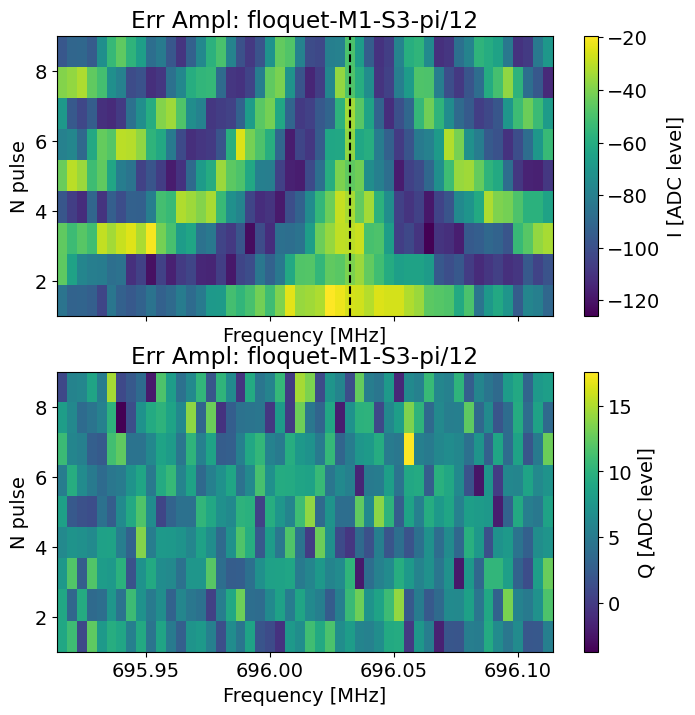

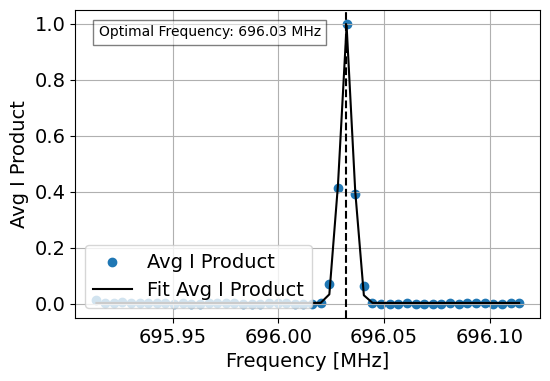

Creating or updating new csv at path: floquet_storage_swap_dataset_copy.csv


In [108]:
# error_amp_exp = error_amp_gain1[0]
# error_amp_exp.analyze(state_fin='e')
# error_amp_exp.display()
# opt_gain = error_amp_exp.data['fit_avgi'][2]
# ds_thisrun.update_gain(f'M1-S{stor_i}', opt_gain)

error_amp_exp = error_amp_freq1[0]
error_amp_exp.analyze(state_fin='e')
error_amp_exp.display()
opt_freq = error_amp_exp.data['fit_avgi'][2]
ds_thisrun.update_freq(f'M1-S{stor_i}', opt_freq)

In [109]:
# Save dataset to file
ds.df = ds_thisrun.df.copy()
ds.save_to_file(ds.filename)

Creating or updating new csv at path: C:\_Lib\python\multimode_expts\floquet_storage_swap_dataset.csv


## Phase accumulation matrix from stark shifts

In [43]:
phase_expts = [[None for _ in range(7)] for _ in range(7)]

Starting experiment for storage modes: 1 from 3


  0%|          | 0/6 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00002_SidebandStarkAmplification_S1_S3.h5
('Error in saving cfg into datafile (experiment.py):', TypeError('Object of type floquet_storage_swap_dataset is not JSON serializable'))


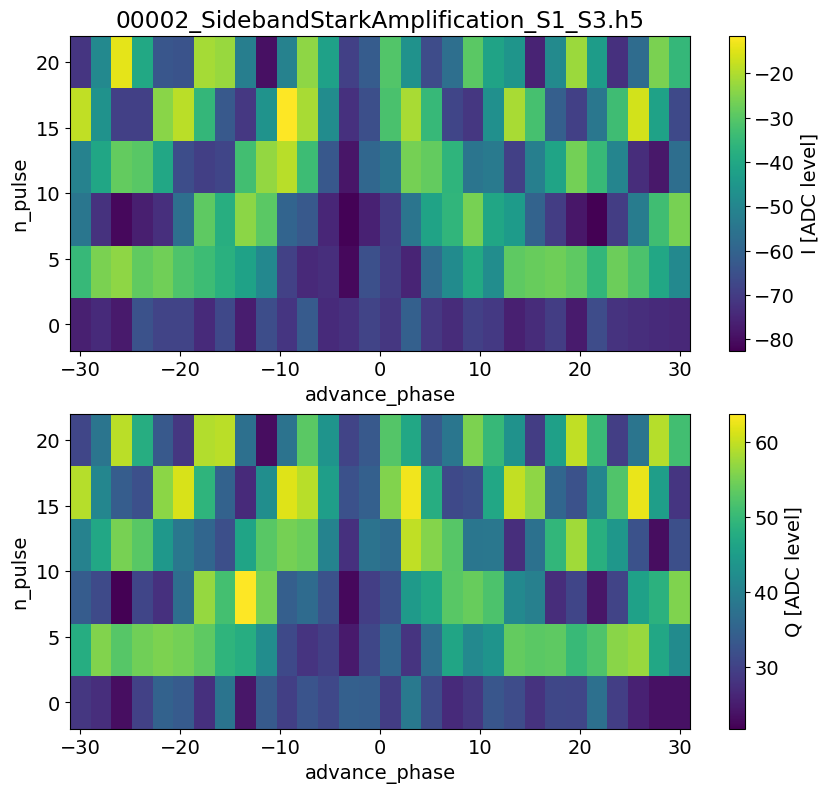

Starting experiment for storage modes: 3 from 1


  0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [53]:
stor_modes_to_run = [1, 3]

for iA, init_storA in enumerate(stor_modes_to_run): #range(1,8):
    for iB, init_storB in enumerate(stor_modes_to_run): #range(1,8):
        if init_storA == init_storB:
            continue
        print("Starting experiment for storage modes:", init_storA, "from", init_storB)
        expt_params = dict(
            expts = 1,
            reps = 100,
            rounds = 1,
            qubits = [0],
            f0g1_cavity = 1,  #  1/2 name of manipulate cavity
            init_stor = 0, # storage mode number to initialize to n=1 Fock state (0 = man)
            ro_stor = 0, # storage mode number that gets read out in the end (0 = man)
            stor_A = init_storA, # storage mode on whose phase accumulation we will evaluate (relative to the stark shifted frequency)
            stor_B = init_storB, # storage mode on which a drive is applied which contributes the phase accumulation
            advance_phases = np.linspace(-30, 30, 30).tolist(),
            n_pulses = np.arange(0, 24, 4).tolist(),
            swept_params = ['n_pulse', 'advance_phase'],
            # usage: if you want to sweep cfg.expt.paramName, 
            # include paramName here in this list 
            # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
            # (You want a list instead of numpy array for better yaml export.)
            # Currently handles 1D and 2D sweeps and plots only.
            # For 2D, order is [outer (y), inner (x)].
            normalize = False, # not sure what this does
            active_reset = False,
            man_reset = True, 
            storage_reset = True, 
            ds_thisrun=ds_thisrun,
        )
    
        qbe = meas.SidebandStarkAmplificationExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"SidebandStarkAmplification_S{expt_params['stor_A']}_S{expt_params['stor_B']}",
            config_file=config_path,
            expt_params=expt_params,
            program=meas.SidebandStarkAmplificationProgram,
            progress=True)
    
        qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
        qbe.go(analyze=False, display=True, progress=True, save=True)
        phase_expts[init_storA - 1][init_storB - 1] = qbe

fitparams [-0.0032551898629319988, 1.003255189862932, -3.1034482758620676, 6.0]


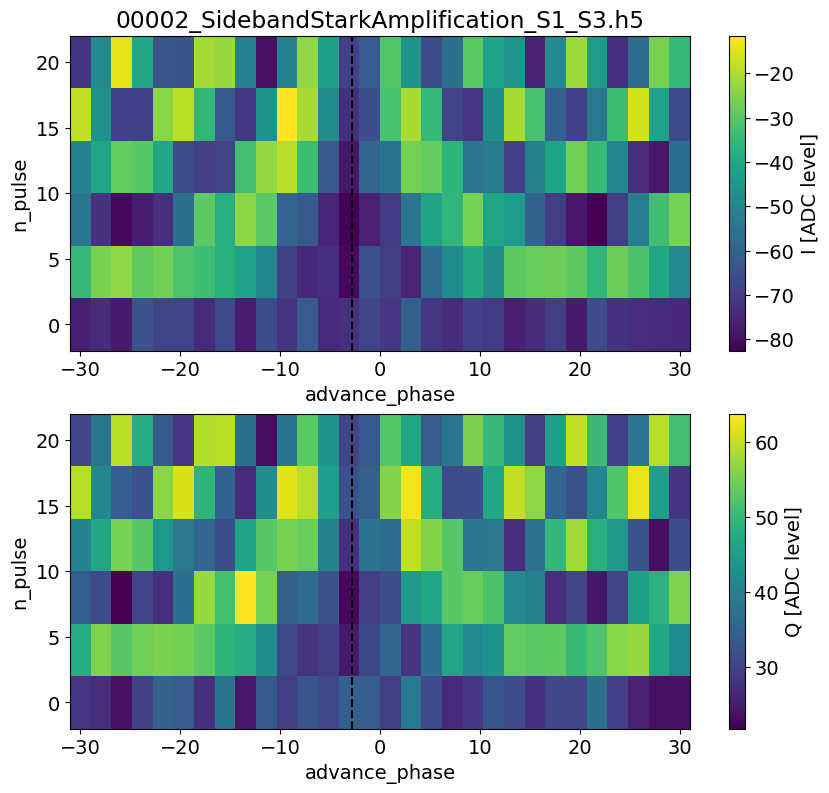

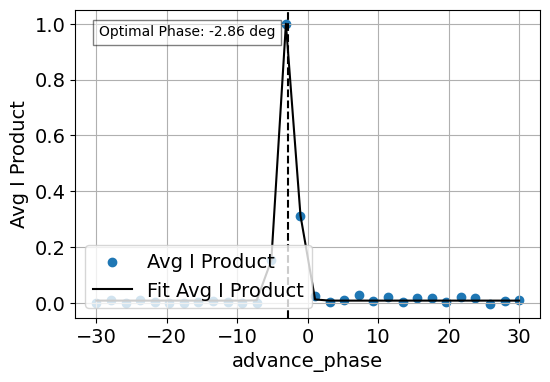

In [54]:
init_storA = 1
init_storB = 3
qbe = phase_expts[init_storA - 1][init_storB - 1]
qbe.analyze(fit=True)
qbe.display(fit=True)

# Qsim

## Initial random try

In [24]:
import multimode_expts.experiments.qsim.qsim_experiments as qsim_exp

experiment_name = 'storage_sweep'

flqSwap = qsim_exp.floquet_swap_class(
    soccfg=soc, 
    path=expt_path, 
    prefix=experiment_name, 
    config_file=config_path, 
    exp_param_file=os.path.join(curr_path, 'configs', 'qsim_exp_cfg.yml')
)

flqSwap.run_sweep( sweep_experiment_name = experiment_name)

Loaded:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 1}
Config is:  {'init_storage': 4, 'start': 0.007, 'step': 60, 'qubits': [0], 'expts': 100, 'reps': 100, 'rounds': 1, 'flux_drive': ['low', 874, 9000, 0.05], 'prepulse': True, 'postpulse': True, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'update_post_pulse_phase': [False, 1.07], 'floquet_cycles': 1}


  0%|          | 0/7 [00:00<?, ?it/s]

[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8483, 15000, 3000], [0.0, 0.0, 0.6312695353859414, 0.7865725563918275], [0, 0, 0, 0], [2, 2, 0, 1], ['g', 'g', 'flat_top', 'flat_top'], [0.035, 0.035, 0.005, 0.005]]
[[3569.4780438937673, 3426.2579958470365, 2009.03, 349.1], [11161, 8

## Sideband Ramsey

This is starting to test our channel phases: when we switch from one channel generator freq to diff freq (activating different storage swaps), does our code preserve phase coherence between the successive (partial) pulses. 

We start from a simple M1-Sx Ramsey: qubit ge, qubit ef, f0g1 to initialize man1 into |1>, then do pi/2 on the beam splitter and wait and another pi/2.

In [72]:
from multimode_expts.experiments.qsim.sideband_ramsey_scramble import SidebandRamseyExperiment

In [12]:
from multimode_expts.experiments.qsim.sideband_ramsey import SidebandRamseyExperiment

importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qsim
imported experiments.qsim.floquet_general
imported experiments.qsim.qsim_base
imported experiments.qsim.qsim_experiments
imported experiments.qsim.sideband_amp_rabi
imported experiments.qsim.sideband_ramsey
imported experiments.qsim.sideband_ramsey_scramble
imported experiments.qsim.sideband_scramble
imported experiments.qsim.sideband_stark
imported experiments.qsim.utils
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.ecd_read_spec
impor

  0%|          | 0/10000 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 4.6000000000000005, which is out of bounds 0.010101010101010102 to 1.5151515151515151. Instead init to 0.7626262626262627
Attempted to init fitparam 1 to 2.0, which is out of bounds 0.010101010101010102 to 1.5151515151515151. Instead init to 0.7626262626262627
Attempted to init fitparam 1 to 3.6, which is out of bounds 0.010101010101010102 to 1.5151515151515151. Instead init to 0.7626262626262627
Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00000_SidebandRamsey_M1S1.h5
Current pi pulse frequency: 3567.3506008394015
Fit frequency from I [MHz]: 0.789504244178576 +/- 0.0917612772037639
Suggested new pi pulse frequency from fit I [MHz]:
 	3566.761096595223
 	3568.34010508358
T2 Ramsey from fit I [us]: 4.122452054885061
Fit frequency from Q [MHz]: 0.8708386624523502 +/- 0.030738824868644207
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3566.679762176949
 	3568.421439501854
T2 Ramsey from fit Q [us]: 6.405362418635468


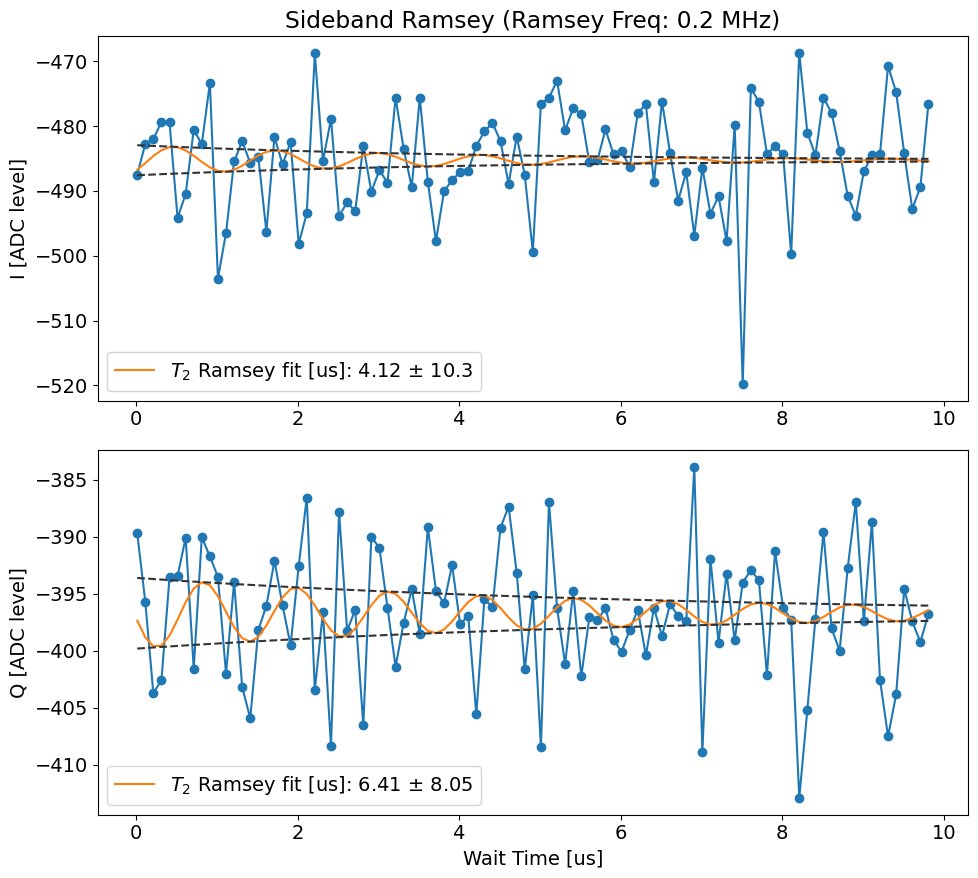

In [15]:
expt_params = dict(
    start = 0.01, # wait time tau [us]
    step = 0.1,  # [us] 1 cycle is 0.0023251488095238095 [us], 2.7901785714285716 # [us]=1200 cycles
    expts = 100,
    ramsey_freq = 0.2, # [MHz]
    detune = 0,
    ac_stark=0.5, # [MHz] not sure how to define sign yet
    # but in any case this needs to be smaller than ramsey_freq
    # because qick can't handle negative numbers
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    stor_no = 1, # storage mode number, 1 to 7
    normalize = False,
    active_reset = True,
    man_reset = True, 
    storage_reset = True, 
    advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
    echoes = [False, 0], # [on/off, number of echoes]
)

sbr = SidebandRamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandRamsey_M1S{expt_params['stor_no']}",
    config_file=config_path,
    expt_params = expt_params,
    progress=True)

sbr.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
# sbr.acquire()
sbr.go(analyze=True, display=True, progress=True, save=True)

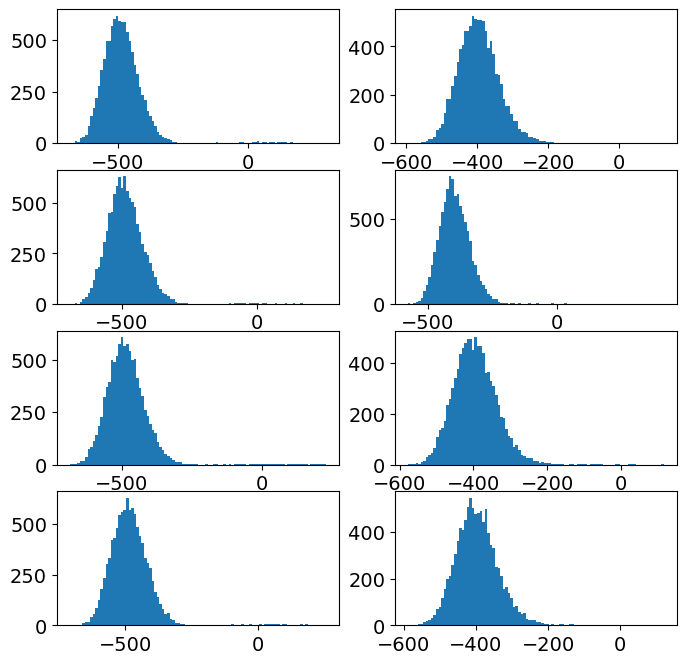

In [16]:
idata = sbr.data['idata']
idata = idata.reshape((len(idata)//4,4))

qdata = sbr.data['qdata']
qdata = qdata.reshape((len(qdata)//4,4))

fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
for kk in range(4):
    axs[kk,0].hist(idata[:,kk], bins=100)
    axs[kk,1].hist(qdata[:,kk], bins=100)
None

In [ ]:
0.327922332524605 # current reset version
0.32806373843420333 # without reset
0.3264759424279595 # reset with 100us wait
0.3274569103286323 # only 0 to N+1
0.328382941835013 # only -N to 0
0.327225195204317 # only 0
0.325693135972055 # n set to 30
0.32566986782848 # add 100 to m1d1

### 2D chevron

In [82]:
from multimode_expts.experiments.qsim.sideband_ramsey import SidebandChevronExperiment

In [90]:
expt_params = dict(
    start = 0.01, # wait time tau [us]
    step = 0.05,  # [us] 1 cycle is 0.0023251488095238095 [us], 2.7901785714285716 # [us]=1200 cycles
    expts = 100,
    ramsey_freq = 0.1, # [MHz]
    ac_stark=0.5,
    detune = 0,
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    stor_no = 1, # storage mode number, 1 to 7
    normalize = False,
    active_reset = False,
    # man_reset = False, 
    # storage_reset = False, 
    advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
    echoes = [False, 0], # [on/off, number of echoes]
)

for stor_no in [5]: #range(1,8):
    expt_params['stor_no'] = stor_no
    sbr = SidebandChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandChevron_M1S{stor_no}",
        config_file=config_path,
        expt_params = expt_params,
        progress=True)
    
    # sbr.acquire()
    sbr.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/51 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00001_SidebandChevron_M1S5.h5


In [85]:
sbr.data.keys()

dict_keys(['avgi', 'avgq', 'amps', 'phases', 'idata', 'qdata', 'xpts', 'ypts'])

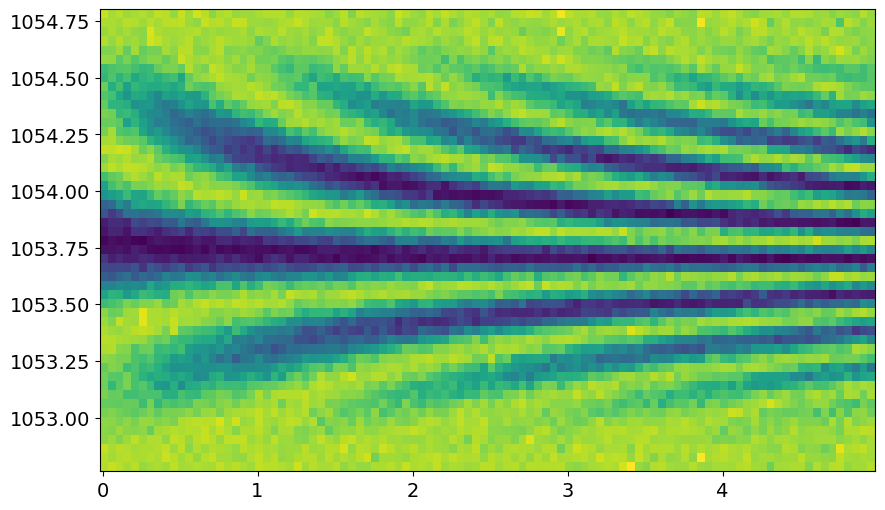

In [91]:
plt.pcolormesh(sbr.data['xpts'], sbr.data['ypts'], sbr.data['avgi'])

In [141]:
asdfg = 105
asdfg //= 2


In [142]:
asdfg

52

## Sideband scramble

In [11]:
from multimode_expts.experiments.qsim.sideband_scramble import SidebandScrambleProgram

importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qsim
imported experiments.qsim.floquet_general
imported experiments.qsim.qsim_base
imported experiments.qsim.qsim_experiments
imported experiments.qsim.sideband_amp_rabi
imported experiments.qsim.sideband_ramsey
imported experiments.qsim.sideband_ramsey_scramble
imported experiments.qsim.sideband_scramble
imported experiments.qsim.sideband_stark
imported experiments.qsim.utils
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.ecd_read_spec
impor

  0%|          | 0/20 [00:00<?, ?it/s]

None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 2)
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 1)
None
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 2)
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 1)
None
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 2)
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 1)
None
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 2)
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 1)
None
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 2)
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 1)
None
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 2)
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 1)
None
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 2)
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 1)
None
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 2)
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1) (7, 1)
None
None
qubit_pulse (7, 1) (7, 0)
qubit_pulse (7, 1

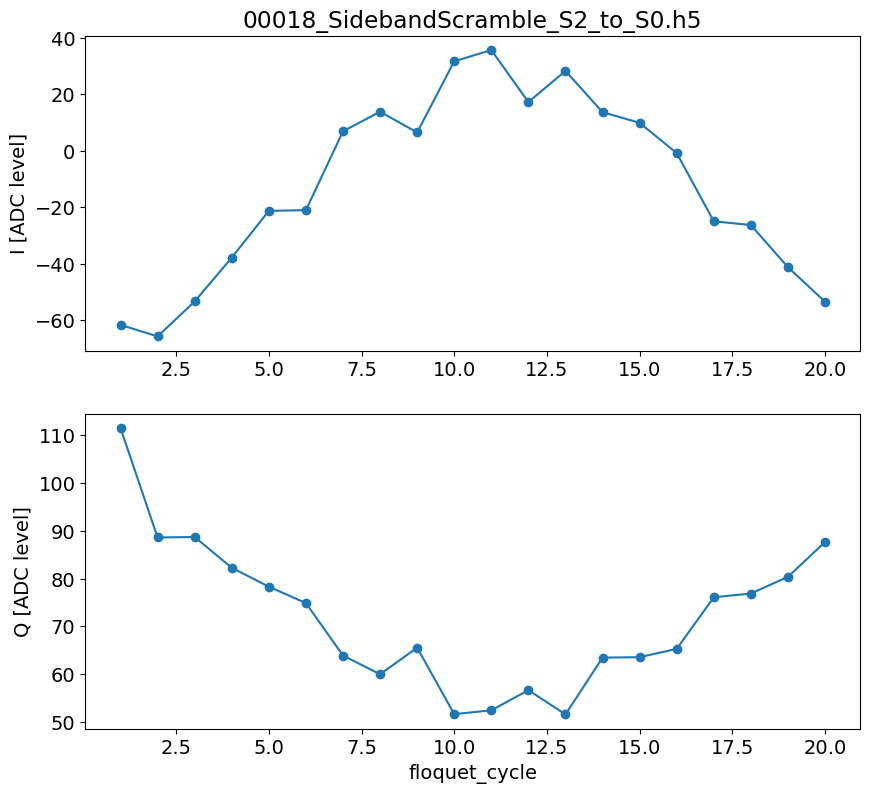

In [74]:
expt_params = dict(
    expts = 1,
    reps = 200,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 2, # storage mode number to initialize to n=1 Fock state
    ro_stor = 0, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,21)),
    detune=0,
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    # advance_phases = list(range(100,200,10)), # advance phase of each successive pulse [degrees]
    advance_phase=0,
    # advance_phase=-140,
    # swept_params = ['advance_phase', 'floquet_cycle'],
    swept_params = ['floquet_cycle'],
    echoes = [False, 0], # [on/off, number of echoes]
)

sbs = meas.QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = meas.SidebandScrambleProgram,
    progress=True)

sbs.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
sbs.go(analyze=False, display=True, progress=True, save=True)

  0%|          | 0/8 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00006_SidebandScramble_S2_to_S0.h5


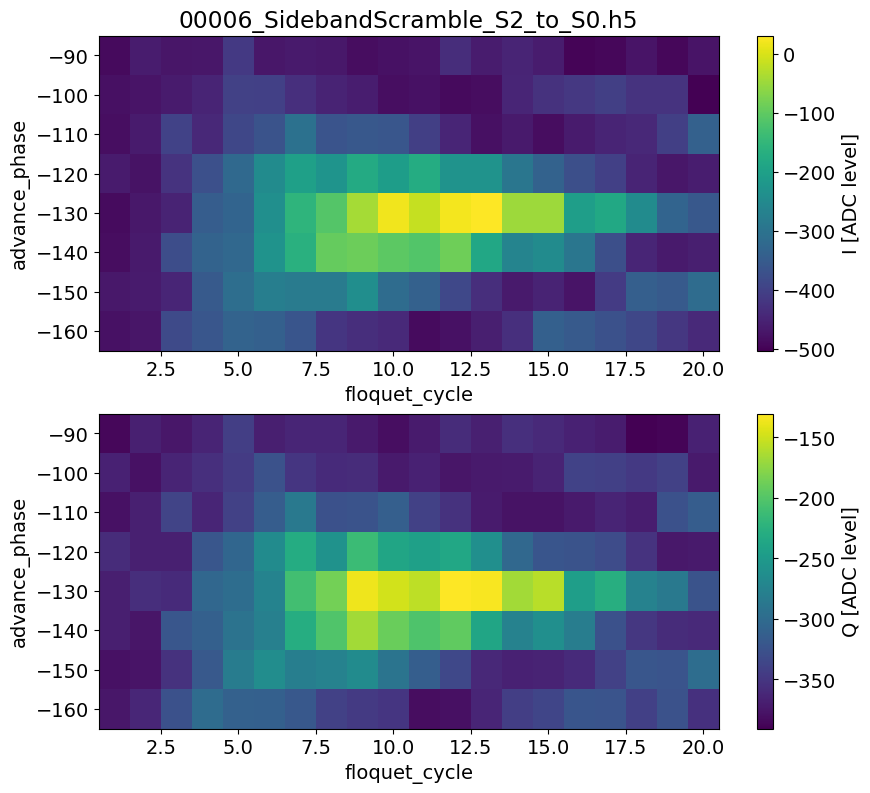

In [29]:
expt_params = dict(
    expts = 1,
    reps = 100,
    rounds = 1,
    qubits = [0],
    f0g1_cavity = 1,  #  1/2 name of manipulate cavity
    init_stor = 2, # storage mode number to initialize to n=1 Fock state
    ro_stor = 0, # storage mode number that gets read out in the end
    # if 0, this means to read out man instead
    floquet_cycles = list(range(1,21)),
    gain_div = 3,
    length_div = 2,
    detune=0,
    normalize = False,
    active_reset = False,
    man_reset = True, 
    storage_reset = True, 
    advance_phases = list(range(-160,-80,10)), # advance phase of each successive pulse [degrees]
    # advance_phase=0,
    swept_params = ['advance_phase', 'floquet_cycle'],
    # swept_params = ['floquet_cycle'],
    echoes = [False, 0], # [on/off, number of echoes]
)

sbs = QsimBaseExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
    config_file=config_path,
    expt_params = expt_params,
    program = SidebandScrambleProgram,
    progress=True)

sbs.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
sbs.go(analyze=False, display=True, progress=True, save=True)

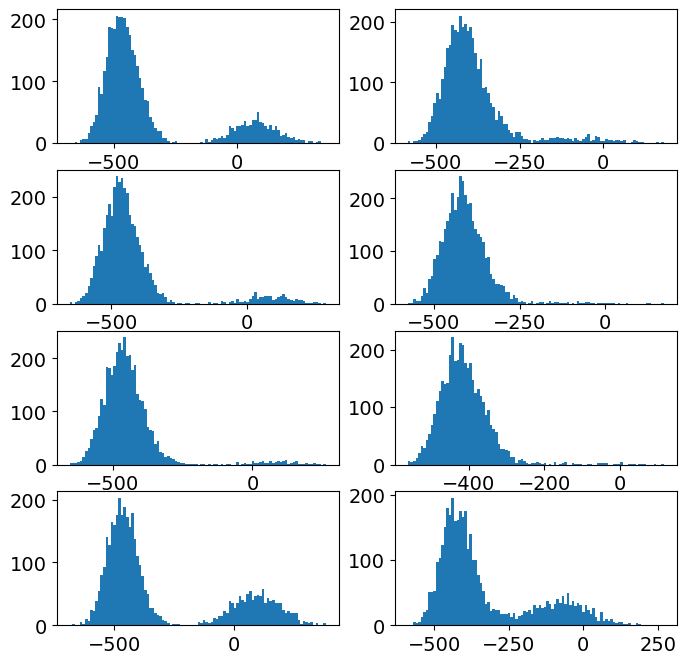

In [98]:
idata = np.array(sbs.data['idata']).ravel()
idata = idata.reshape((len(idata)//4,4))

qdata = np.array(sbs.data['qdata']).ravel()
qdata = qdata.reshape((len(qdata)//4,4))

fig, axs = plt.subplots(nrows=4,ncols=2, figsize=(8,8))
for kk in range(4):
    axs[kk,0].hist(idata[:,kk], bins=100)
    axs[kk,1].hist(qdata[:,kk], bins=100)
None

In [263]:
for init_stor in range(3,8):
    # for ro_stor in range(8):
    ro_stor = 0
    for detune in np.linspace(-0.2,0.2,21):
        expt_params = dict(
            expts = 1,
            reps = 1000,
            rounds = 1,
            qubits = [0],
            f0g1_cavity = 1,  #  1/2 name of manipulate cavity
            init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
            ro_stor = ro_stor, # storage mode number that gets read out in the end
            # if 0, this means to read out man instead
            floquet_cycles = list(range(1,101)),
            detune=detune,
            normalize = False,
            active_reset = True,
            man_reset = True, 
            storage_reset = True, 
            advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
            echoes = [False, 0], # [on/off, number of echoes]
        )
        
        sbs = SidebandScrambleExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"SidebandScramble_S{expt_params['init_stor']}_to_S{expt_params['ro_stor']}",
            config_file=config_path,
            expt_params = expt_params,
            progress=True)
        
        sbs.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
        sbs.go(analyze=False, display=False, progress=False, save=True)

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00001_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00002_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00003_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00004_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00005_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00006_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00007_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00008_SidebandScramble_S3_to_S0.h5
Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00009_SidebandS

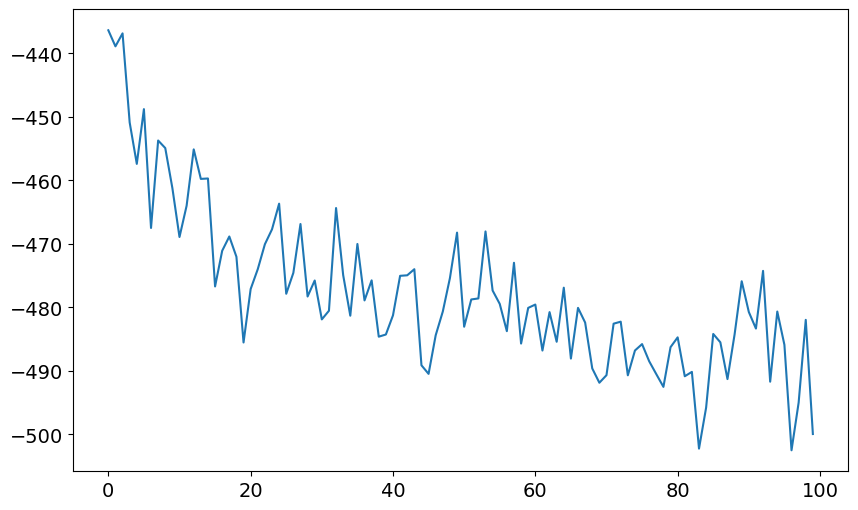

In [259]:
plt.plot(ss[9].data['avgi'])

## Amplitude Rabi

In [11]:
from multimode_expts.experiments.qsim.sideband_amp_rabi import SidebandAmpRabiExperiment

importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qsim
imported experiments.qsim.floquet_general
imported experiments.qsim.qsim_base
imported experiments.qsim.qsim_experiments
imported experiments.qsim.sideband_amp_rabi
imported experiments.qsim.sideband_ramsey
imported experiments.qsim.sideband_ramsey_scramble
imported experiments.qsim.sideband_scramble
imported experiments.qsim.utils
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.ecd_read_spec
imported experiments.qubit_cavity.non_demoluti

In [47]:
for init_stor in range(1,8):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 500,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        detunes=np.linspace(-2,2,101).tolist(),
        gains=list(range(0,20000,100)),
        length=3, # us rabi pulse legnth
        normalize = False,
        active_reset = True,
        man_reset = True, 
        storage_reset = True, 
        advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    sare = SidebandAmpRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandAmpRabi_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params = expt_params,
        progress=True)
    
    sare.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
    sare.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S1.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S2.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S3.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S4.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S5.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S6.h5


  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250506_qsim\data\00000_SidebandAmpRabi_S7.h5


## Find phase offset for ramsey

In [14]:
from multimode_expts.experiments.qsim.sideband_stark import SidebandStarkExperiment, SidebandStarkProgram

In [15]:
# for init_stor in range(1, 8):
for init_stor in range(1, 3):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 100,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        # detunes=np.linspace(-0.1,0.1,101).tolist(),
        detune = 0,
        advance_phases=np.linspace(-90,90,31).tolist(),
        # wait=10, # wait time between two hpi pulses in us
        waits = np.linspace(0,30,31).tolist(),
        swept_params = ['advance_phase', 'wait'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        # advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    sta = SidebandStarkExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandStark_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params = expt_params,
        program=SidebandStarkProgram,
        progress=True)
    
    sta.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    sta.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/31 [00:00<?, ?it/s]

pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1', 'pi', 0]
channel name man
pulse param ['M1-S1', 'pi', 0]
channel name storage
pulse_data [[3571.6994214615424 3428.4457610447353 2011.6693654525284
  348.702401768369]
 [3429 2770 8000 3000]
 [0.0 0.0 0.5408883810926033 0.9174265564762912]
 [0 0 0 0]
 [2 2 0 1]
 ['gauss' 'gauss' 'flat_top' 'flat_top']
 [0.035 0.035 0.005 0.005]]
pulse param ['M1', 'pi', 0]
channel name man
pulse_data [[2011.6693654525284]
 [8000]
 [0.5408883810926033]
 [0]
 [0]
 ['flat_top']
 [0.005]]
pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1

  0%|          | 0/31 [00:00<?, ?it/s]

pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1', 'pi', 0]
channel name man
pulse param ['M1-S2', 'pi', 0]
channel name storage
pulse_data [[3571.6994214615424 3428.4457610447353 2011.6693654525284
  520.1370383281906]
 [3429 2770 8000 5000]
 [0.0 0.0 0.5408883810926033 1.084581933496189]
 [0 0 0 0]
 [2 2 0 1]
 ['gauss' 'gauss' 'flat_top' 'flat_top']
 [0.035 0.035 0.005 0.005]]
pulse param ['M1', 'pi', 0]
channel name man
pulse_data [[2011.6693654525284]
 [8000]
 [0.5408883810926033]
 [0]
 [0]
 ['flat_top']
 [0.005]]
pulse param ['ge', 'hpi', 0]
channel name qubit
pulse param ['ge', 'parity_M1', 0]
channel name qubit
pulse param ['ge', 'hpi', 180]
channel name qubit
pulse param ['ge', 'pi', 0]
channel name qubit
pulse param ['ef', 'pi', 0]
channel name qubit
pulse param ['M1

c:\Users\26049\.conda\envs\slab\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


AC Stark freq: 0.199627MHz


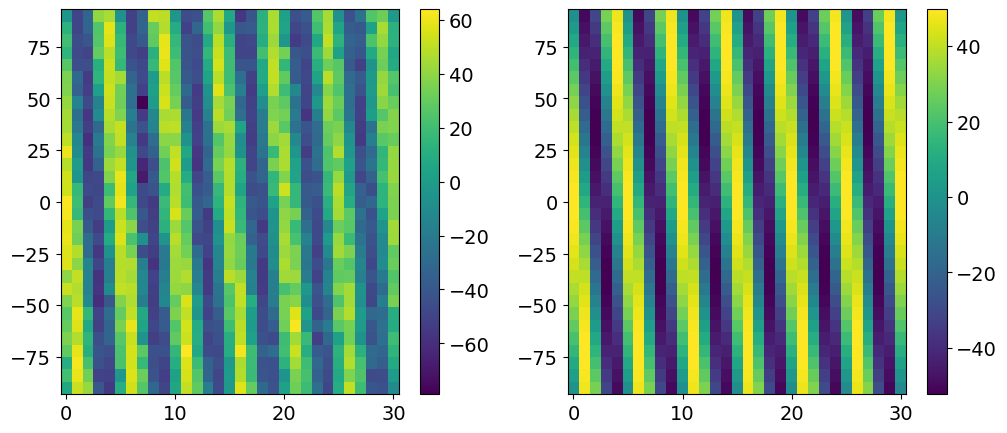

In [17]:
sta.analyze()

In [19]:
for init_stor in [1]: #range(1,8):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 500,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        # detunes=np.linspace(-0.1,0.1,101).tolist(),
        detune = 0,
        phases=np.linspace(-90,90,91).tolist(),
        # wait=10, # wait time between two hpi pulses in us
        waits = np.linspace(0,2,51).tolist(),
        swept_params = ['phase', 'wait'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = True,
        man_reset = True, 
        storage_reset = True, 
        advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    sta = SidebandStarkExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandStark_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params = expt_params,
        progress=True)
    
    sta.cfg.device.readout.relax_delay = [200]  # Wait time between experiments [us]
    sta.go(analyze=False, display=False, progress=True, save=True)

  0%|          | 0/91 [00:00<?, ?it/s]

KeyboardInterrupt: 

### new base class general 2D

In [20]:
from multimode_expts.experiments.qsim.sideband_stark import SidebandStarkProgram
from multimode_expts.experiments.qsim.qsim_base import QsimBaseExperiment

  0%|          | 0/101 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250708_qsim\data\00002_SidebandStark_S2.h5


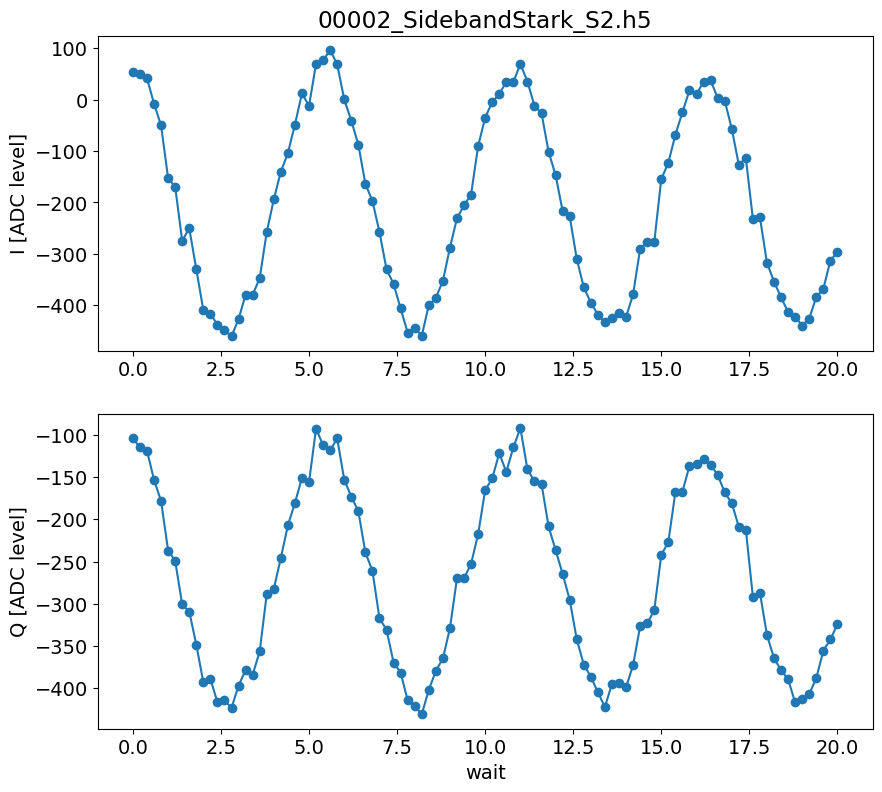

In [106]:
for init_stor in [2]: #range(1,8):
    ro_stor = 0
    expt_params = dict(
        expts = 1,
        reps = 100,
        rounds = 1,
        qubits = [0],
        f0g1_cavity = 1,  #  1/2 name of manipulate cavity
        init_stor = init_stor, # storage mode number to initialize to n=1 Fock state
        ro_stor = ro_stor, # storage mode number that gets read out in the end
        # if 0, this means to read out man instead
        detune = 0,
        # detunes=np.linspace(-0.1,0.1,101).tolist(),
        advance_phase = 0, # advance phase of second pi/2 by this much [degrees]
        # advance_phases=np.linspace(-90,90,91).tolist(),
        # wait=10, # wait time between two hpi pulses in us
        waits = np.linspace(0,20,101).tolist(),
        swept_params = ['wait'],
        # usage: if you want to sweep cfg.expt.paramName, 
        # include paramName here in this list 
        # AND include cfg.expt.paramNames (note the s) as a list of values to step thru.
        # (You want a list instead of numpy array for better yaml export.)
        # Currently handles 1D and 2D sweeps and plots only.
        # For 2D, order is [outer, inner].
        normalize = False,
        active_reset = False,
        man_reset = True, 
        storage_reset = True, 
        echoes = [False, 0], # [on/off, number of echoes]
    )
    
    qbe = QsimBaseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"SidebandStark_S{expt_params['init_stor']}",
        config_file=config_path,
        expt_params=expt_params,
        program=SidebandStarkProgram,
        progress=True)
    
    qbe.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    qbe.go(analyze=False, display=True, progress=True, save=True)

# Ramp current

In [ ]:
# coupler
dcflux = YokogawaGS200(address="192.168.137.148")
dcflux.set_output(True)
dcflux.set_mode('current')
dcflux.ramp_current(0.00032, sweeprate=0.0001)

In [ ]:
# jpa
dcflux = YokogawaGS200(address="192.168.137.149")
dcflux.set_output(True)
dcflux.set_mode('current')
dcflux.ramp_current(0.000, sweeprate=0.002)

In [ ]:
# dcflux = YokogawaGS200(address="192.168.137.148")
#     dcflux.set_output(True)
#     dcflux.set_mode('current')
#     dcflux.ramp_current(0.000, sweeprate=0.002)